# Indonesian Life Expectancy

This notebook examines life expectancy across Indonesian cities in 2021, how other factors interact with life expectancy, and explores machine learning predictions based on those factors.

Specifically, I will explore two problems within this topic - one regression problem, and one classification problem:
- Can life expectancy be predicted for a city based on other factors? (regression)
- Can the province a city is located in be predicted based on life expectancy and another factor? (classification)

This topic is interesting to me because I would like to see if anything interesting can be learned about life expectancy by examining how it relates to other factors in a geographic area.

## Dataset

This notebook uses a dataset from Kaggle:

**Dunrui, D. (2023). Socio-Economic of Indonesia in 2021 [Data set]. Kaggle. https://www.kaggle.com/datasets/dannytheodore/socio-economic-of-indonesia-in-2021**

This dataset includes 514 rows with 7 features, which will be described in more detail below.

## Install Requirements

In [276]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

## Load Data

First, we will load the dataset from a CSV.

In [278]:
df = pd.read_csv('data/2021socio_economic_indonesia.csv')

df.head()

,province,cities_reg,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
0,Aceh,Simeulue,18.98,2.275,65.240,9.48,7148
1,Aceh,Aceh Singkil,20.36,2.425,67.355,8.68,8776
2,Aceh,Aceh Selatan,13.18,5.531,64.360,8.88,8180
3,Aceh,Aceh Tenggara,13.41,5.063,68.155,9.67,8030
4,Aceh,Aceh Timur,14.45,10.616,68.705,8.21,8577


## Assess Cleaning Requirement

Since none of the datasets columns has missing entries or problematic values, I do not need to perform any cleaning on the dataset before continuing.

## Initial Data Summary

Our dataset is a list of Indonesian cities with their corresponding province (`province`), and 5 scalar attributes:
- Percentage of Poor Population (`poorpeople_percentage`)
- GDP (in billions) (`reg_gdp`)
- Life Expectancy (`life_exp`)
- Average Years of Schooling (`avg_schooltime`)
- Expenditure per Capita (`exp_percap`)

The following code reveals the distribution of values for each attribute

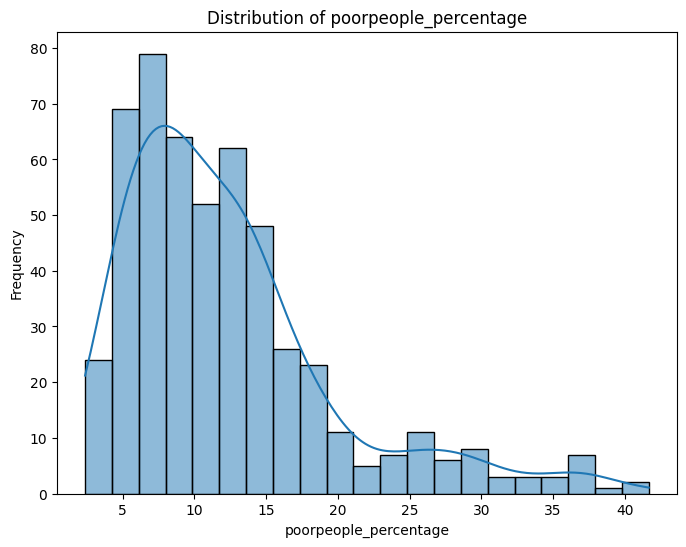

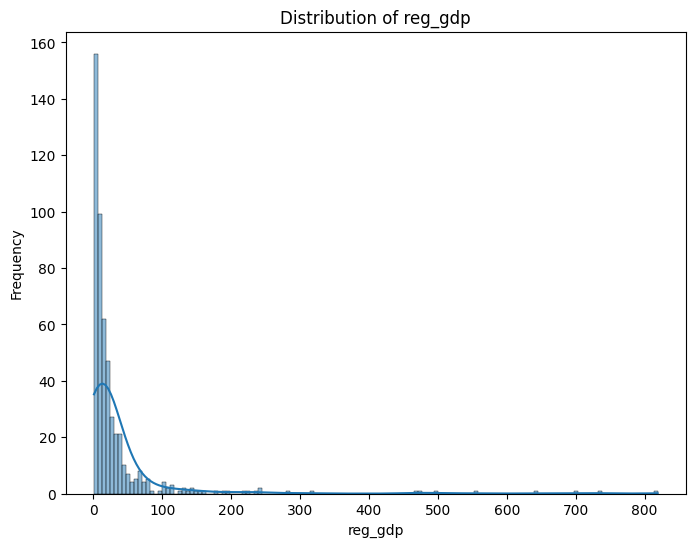

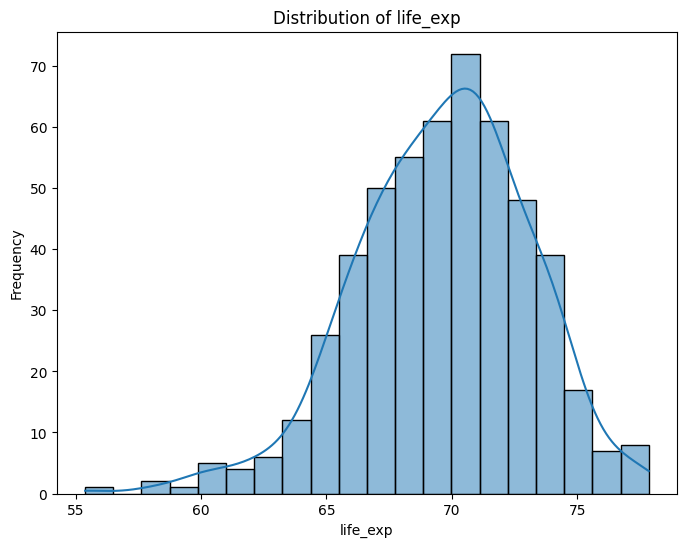

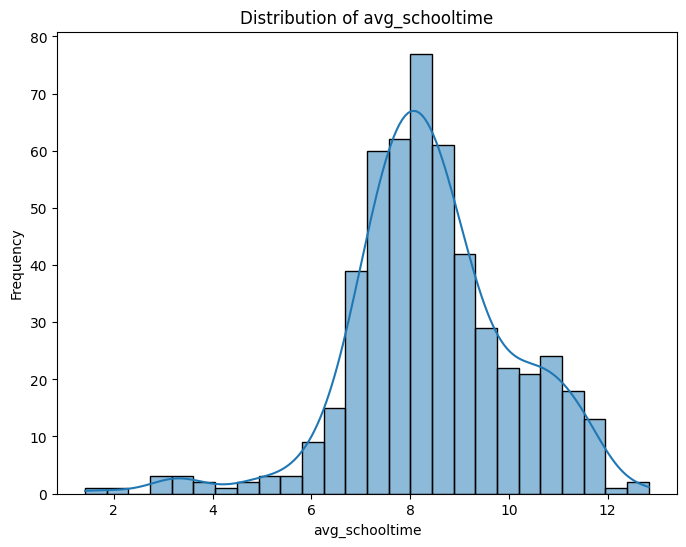

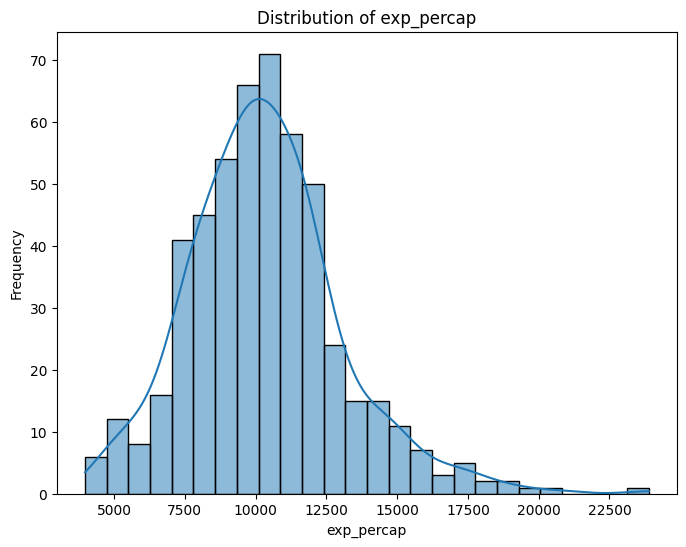

In [279]:
# Identify scalar columns
scalar_columns = df.select_dtypes(include=['number']).columns

# Plot the data distribution
for column in scalar_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

## Relationships Between Factors

We can now examine the relationships of the available factors.

I will start by examining a pairplot to get a general sense of the relationships between factors.

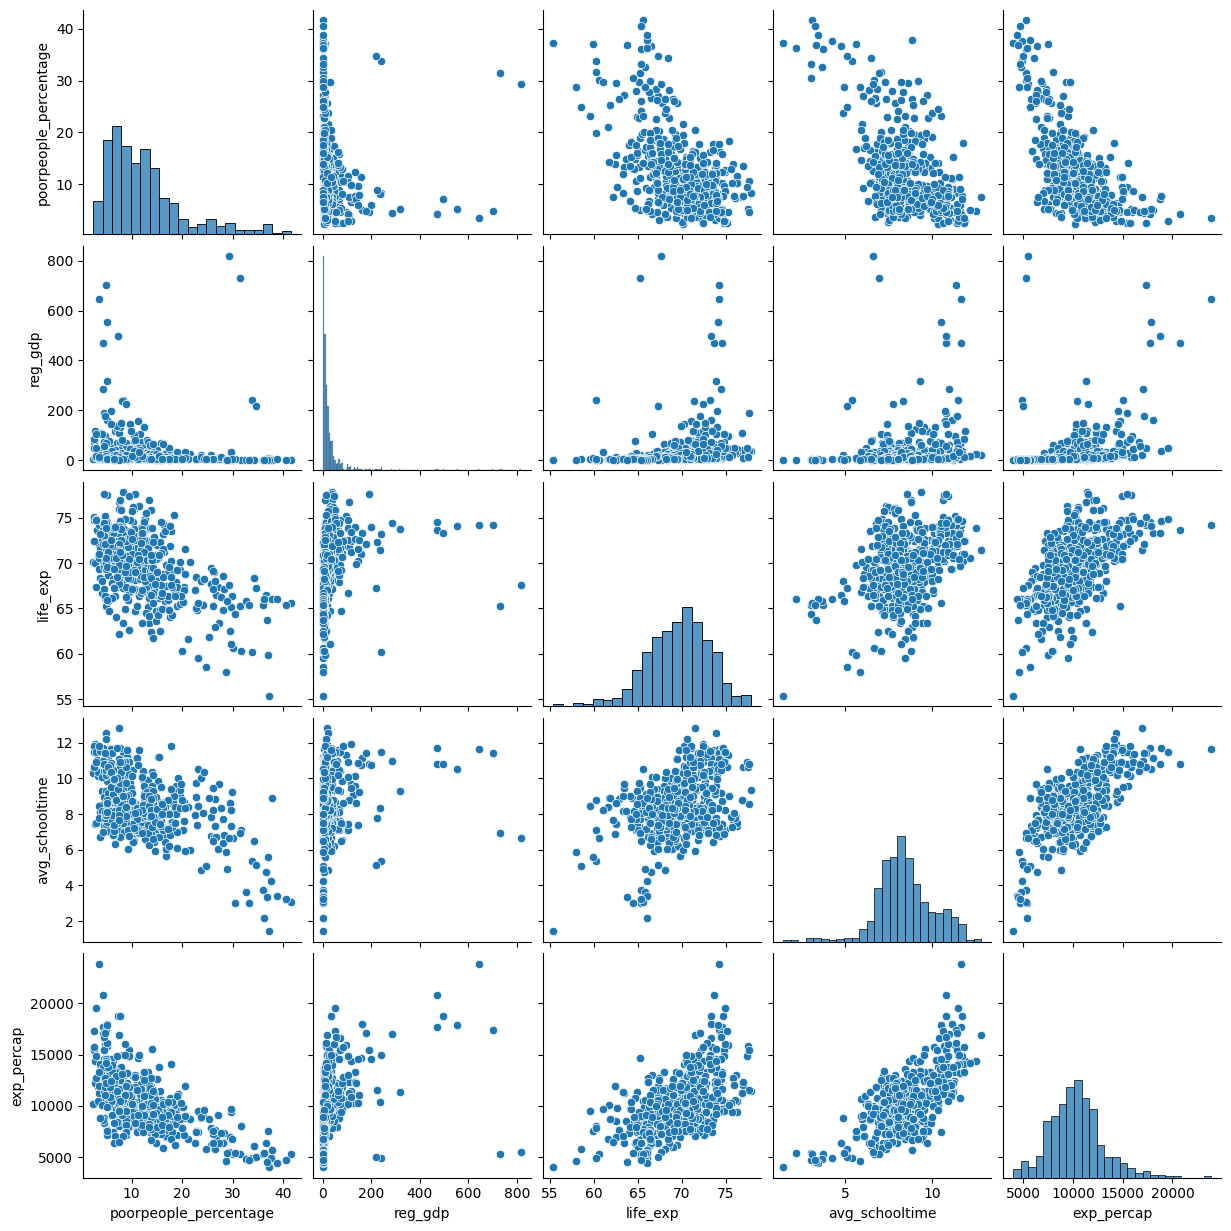

In [280]:
sns.pairplot(df)

Based on this pairplot, I don't think that any factors seem so highly correlated that they need to be omitted, however I will also examine a correlation matrix to confirm.

In [281]:
scalar_columns = df.select_dtypes(include=['number'])

scalar_columns.corr()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
poorpeople_percentage,1.000000,-0.078131,-0.538820,-0.543909,-0.644222
reg_gdp,-0.078131,1.000000,0.209147,0.165403,0.333952
life_exp,-0.538820,0.209147,1.000000,0.414511,0.565775
avg_schooltime,-0.543909,0.165403,0.414511,1.000000,0.668847
exp_percap,-0.644222,0.333952,0.565775,0.668847,1.000000


Since none of these features has a correlation over 7, I can leave them all in.

## Problem 1: Predicting Life Expectancy

The first problem we will explore is a regression problem: predicting the life expectancy of a city based on other factors provided in the dataset.

 
### Finding The Best Predictors

We will now find the best predictors of life expectancy by fitting an OLS model from each factor, and finding the model with the highest R squared value.

In [282]:

columns_series = pd.Series(df.columns)
r_df = pd.DataFrame({'Predictor': columns_series})

r_df['R Value'] = columns_series.apply(lambda col: smf.ols(formula=f'life_exp ~ {col}', data=df).fit().rsquared)

ranked_r_df = r_df.sort_values(by='R Value', ascending=False)

print(ranked_r_df)

               Predictor   R Value
1             cities_reg  1.000000
4               life_exp  1.000000
0               province  0.592876
6             exp_percap  0.320102
2  poorpeople_percentage  0.290327
5         avg_schooltime  0.171819
3                reg_gdp  0.043743


When examining the R value of each factor as a predictor for a city's life expectancy, we see the highest predictor is actually the province the city is located in.

This is an interesting finding and not what I expected - I would have expected that economic or educational factors would be the better predictor of life expectancy.

Aside from province, we see the highest predictors are Expenditure per Capita and Percentage of Poor Population (both significantly lower). 

### Multi-Linear Regresssion

Knowing the R value for each single predictor, we can now try a multi-linear regression with multiple factors to see if the R value increases.

We will add the additional predictors in order of highest R value for the single predictors, and check the R value for the multi-linear regresssion after each step.

In [283]:
formula = 'life_exp ~ province'

other_factors = ['exp_percap', 'poorpeople_percentage', 'avg_schooltime', 'reg_gdp']

for factor in other_factors:
    formula += f' + {factor}'
    model = smf.ols(formula=formula, data=df).fit()
    print(formula)
    print(f'r squared: {model.rsquared}')



life_exp ~ province + exp_percap
r squared: 0.6891623742061842
life_exp ~ province + exp_percap + poorpeople_percentage
r squared: 0.6955380675547158
life_exp ~ province + exp_percap + poorpeople_percentage + avg_schooltime
r squared: 0.7259004284237491
life_exp ~ province + exp_percap + poorpeople_percentage + avg_schooltime + reg_gdp
r squared: 0.7292148886157255


We find that the R value increases with each added predictor, but the benefit of adding reg_gdp is minimal, so we can leave that out of our formula.

### Manual Verification of Predictions

Aside from examining the R value of the model, we can also manually examine how the model's predictions for a test dataset compares to actual life expectancy, after being trained on a separate training dataset.

In [284]:
# split the data into train & test subsets
train, test = train_test_split(df, test_size=0.25)

# use the multi-linear formula we previously identified to train the model on the training subset
formula = 'life_exp ~ province + exp_percap + poorpeople_percentage + avg_schooltime'
model = smf.ols(formula=formula, data=train).fit()

# make predictions on the test dataset using the predictors in our formula
X_test = test[['cities_reg', 'province', 'exp_percap', 'poorpeople_percentage', 'avg_schooltime']]
predictions = model.predict(X_test)

# compile a comparison dataframe of actual vs predicted life expectancy.
results_df = pd.DataFrame({
    'city': test['cities_reg'],
    'actual_life': test['life_exp'],
    'predicted_life': predictions
})

results_df

,city,actual_life,predicted_life
45,Labuhan Batu Utara,69.535,68.362892
96,Kota Jambi,72.700,72.699169
61,Padang Pariaman,68.915,69.231113
53,Kota Binjai,72.430,70.333367
390,Toli-Toli,66.155,67.839523
382,Kota Bitung,71.040,70.998963
481,Maybrat,65.240,64.298713
132,Tulangbawang,69.960,68.423310
128,Lampung Timur,70.725,68.388480
234,Lumajang,70.170,70.324271


## Problem 2: Predicting Province

The next problem we will explore is a classification problem: predicting the province of a city based on the other factors in the data. 

### Examining Potential for SVM

One possible approach for predicting province would be graphing the cities based on two factors, and using a SVM to predict their province based on their location on the graph.

To determine whether this approach seems feasible, I want to see if there are two features that, when used to graph the cities, seems to place the cities in distinguishable areas.

I will iterate over the combinations of factors, graphing each combination as a scatter plot, and coloring the dots according to the province, to see in which combinations the provinces seems most grouped in the plot.



In [285]:
# Helper function to display a scatter plot of city data
def display_city_scatter_plot(data, x, y, hue='province', title='', palette='viridis'):
    
    if title == '':
        title = f'{x} & {y}'
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x, y=y,  hue=hue, palette=palette, s=100)
    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='Province')
    plt.grid(True)
    plt.title(title)
    
    plt.show()

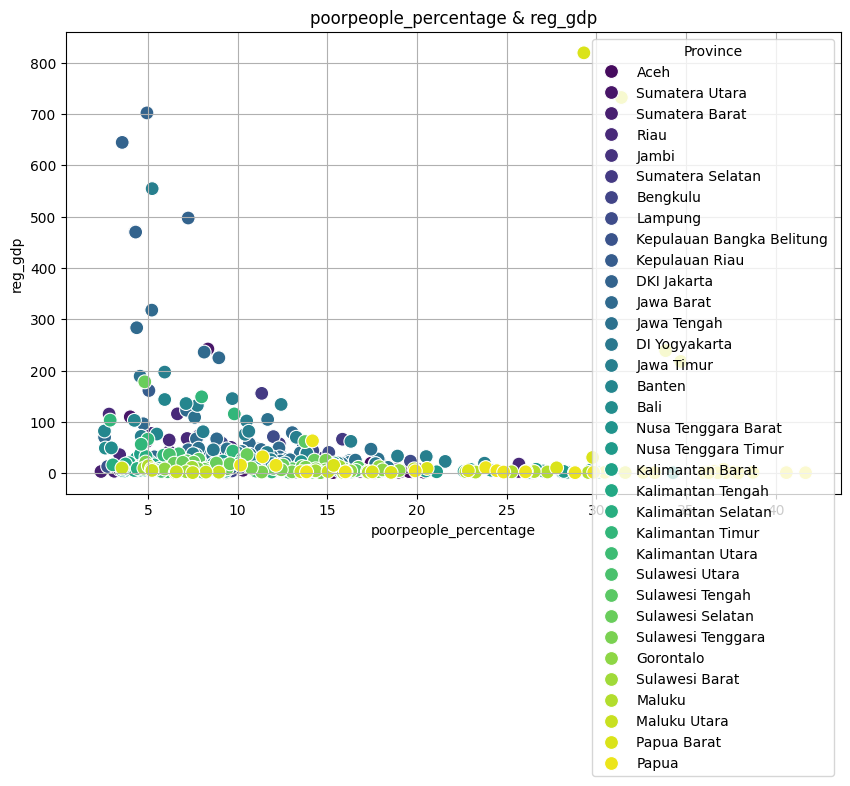

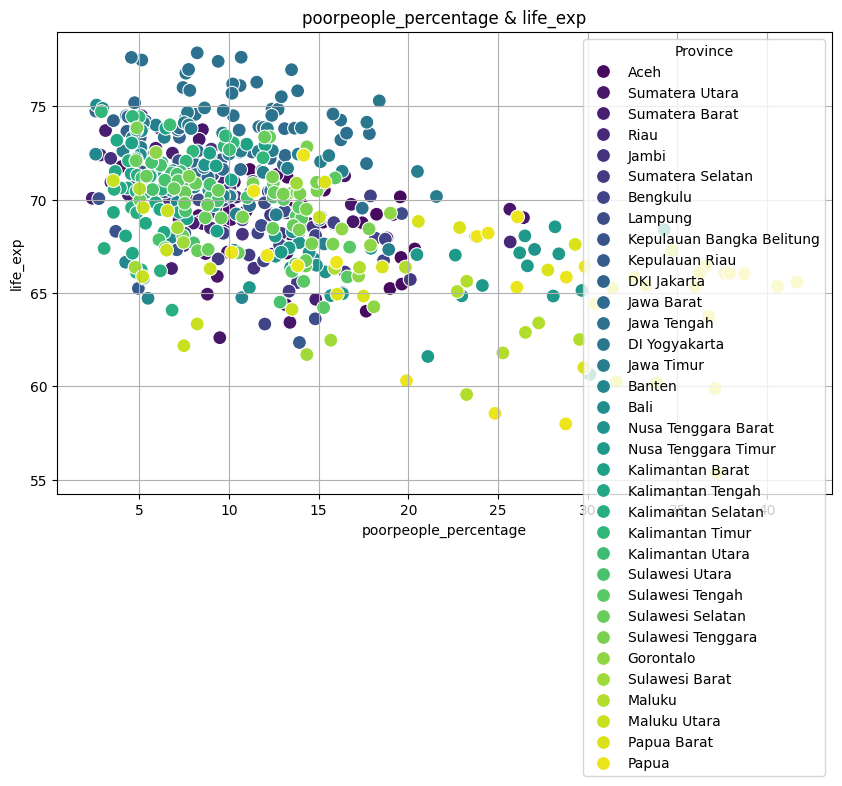

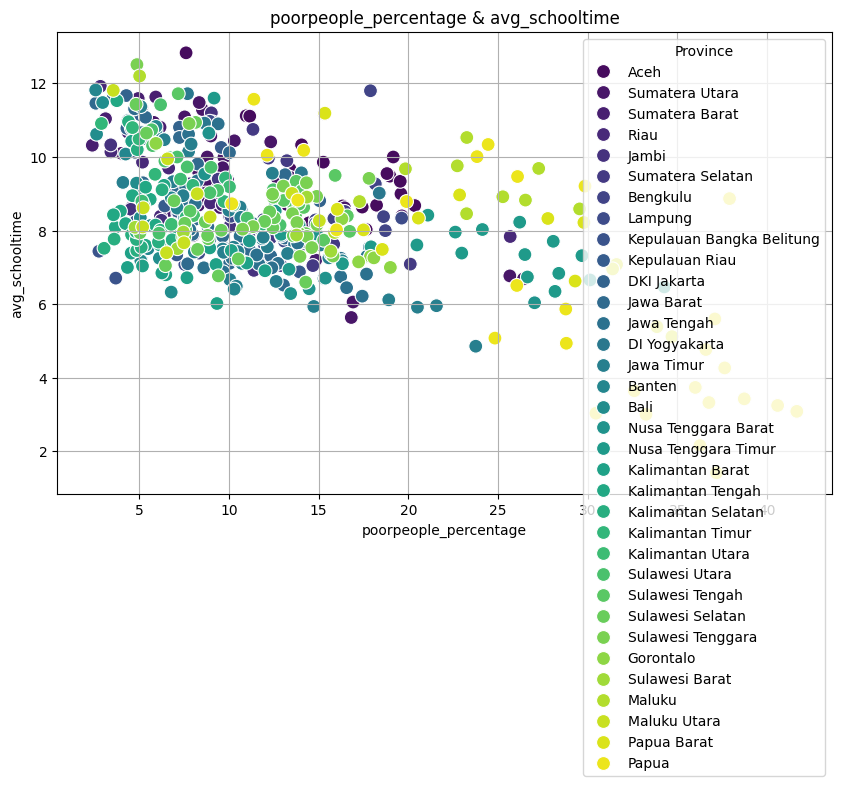

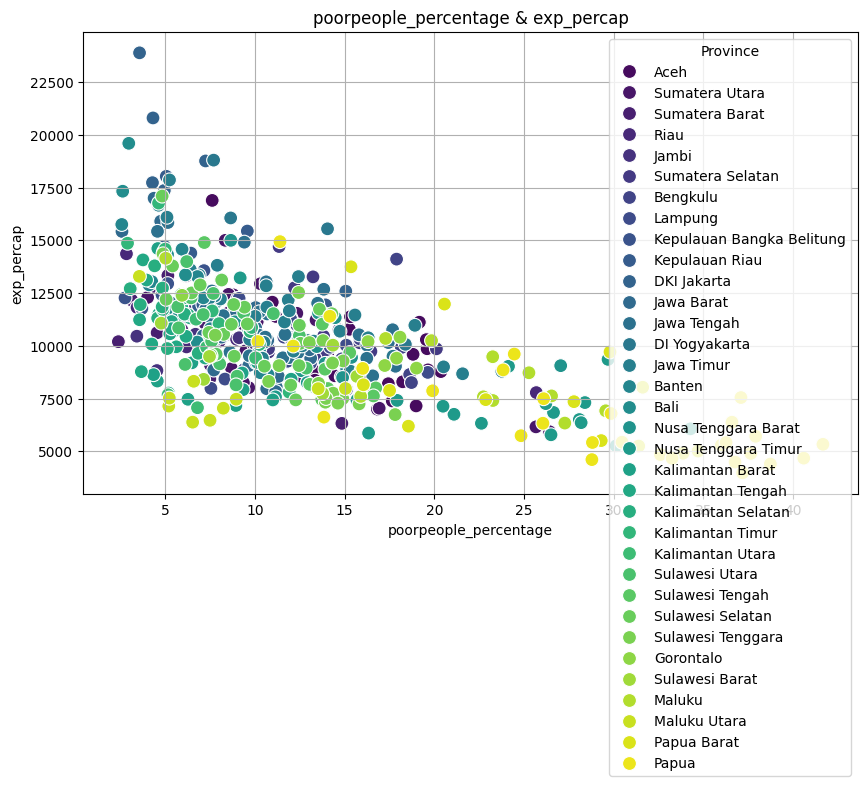

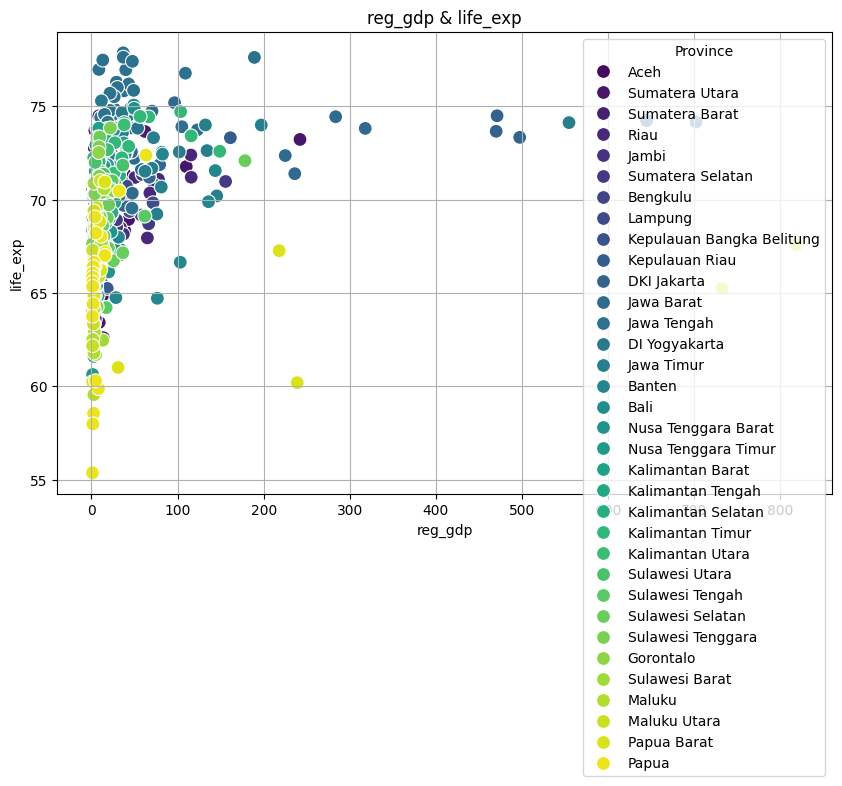

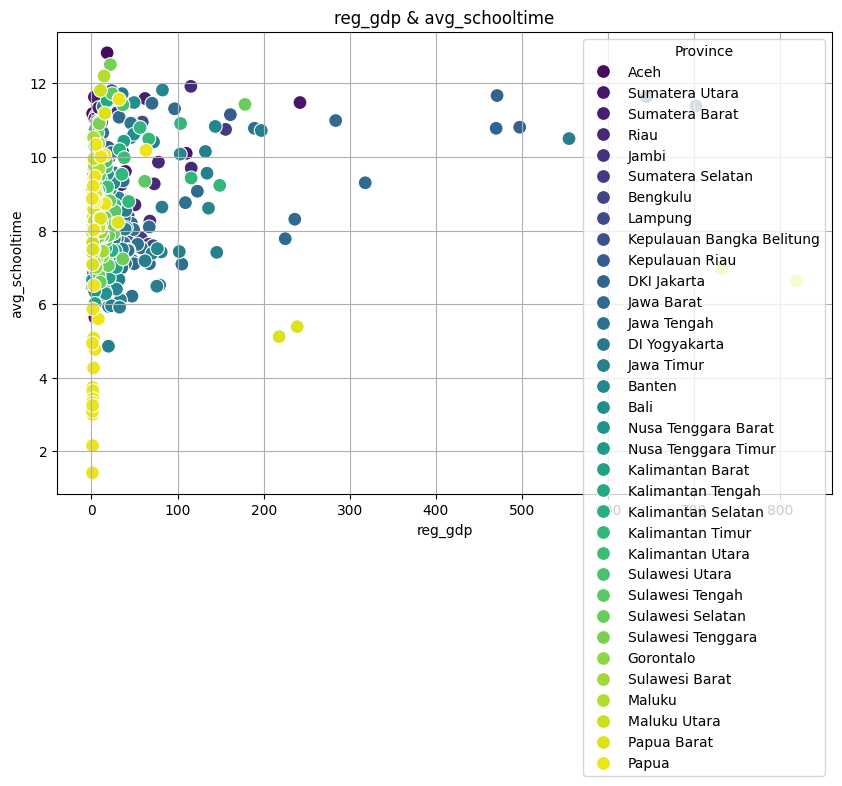

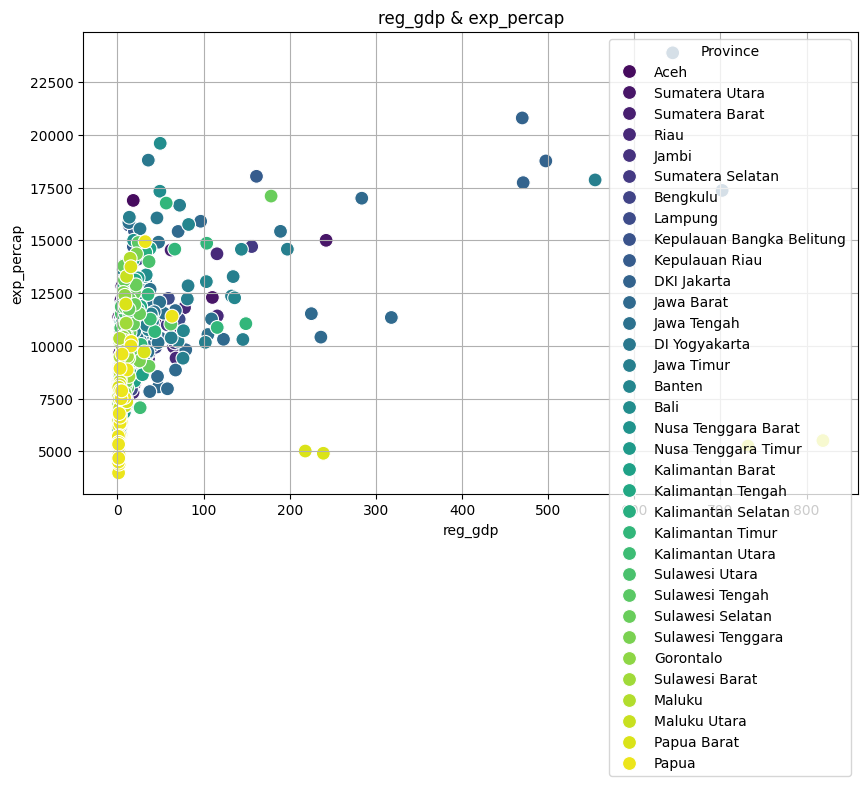

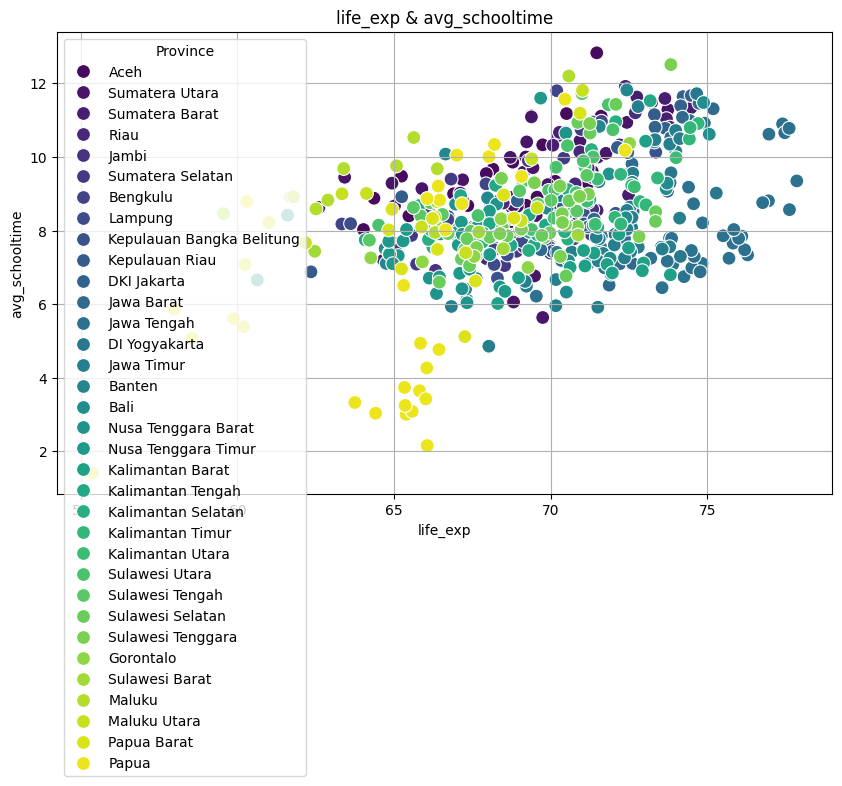

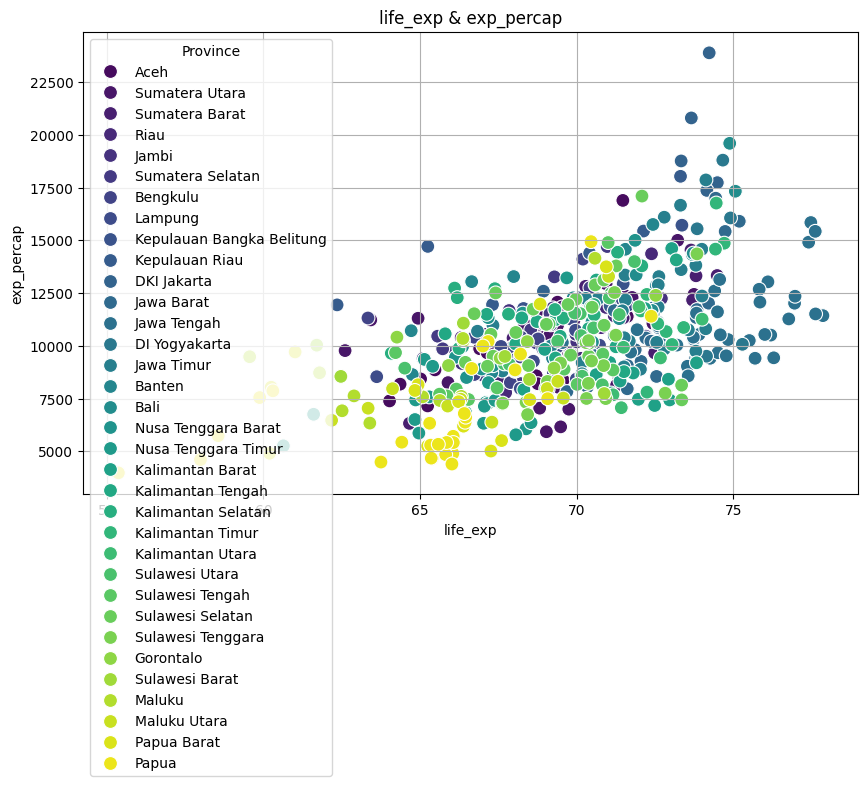

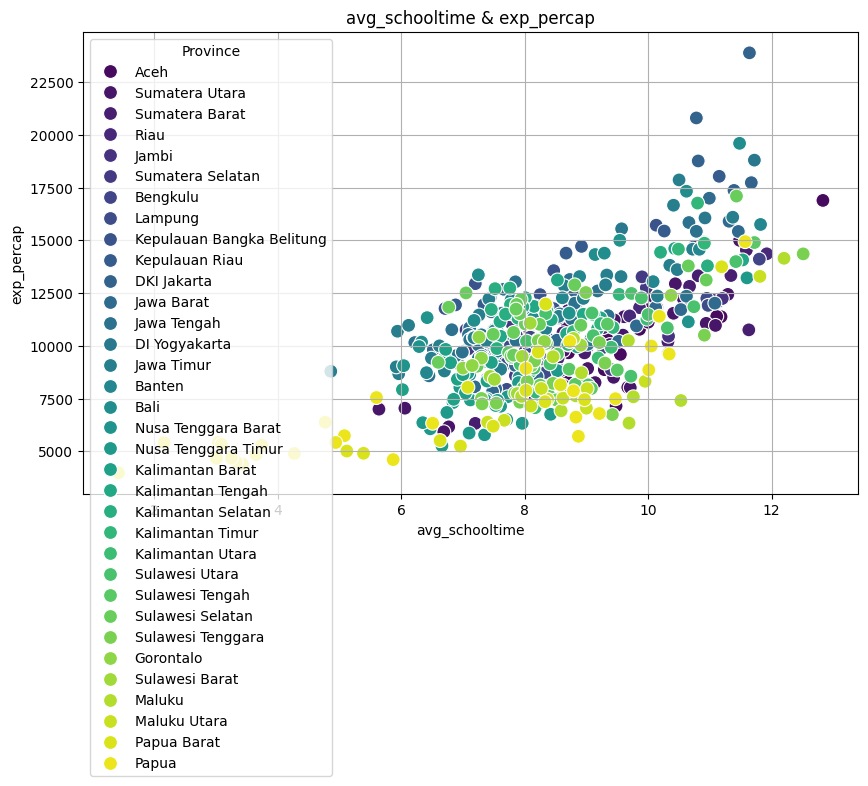

In [286]:
scalar_columns = df.select_dtypes(include=['number']).columns

seen_combos = []

def get_combo_string(s1, s2):
    return f"{sorted([s1, s2])}"

# Plot the data distribution
for column1 in scalar_columns:
    for column2 in scalar_columns:
        if column1 != column2:
            combo_string = get_combo_string(column1, column2)
            if combo_string not in seen_combos:
                
                display_city_scatter_plot(data=df, x=column1, y=column2)
                
                seen_combos.append(combo_string)


Based on these initial plots, I will choose to plot based on life expectancy and average schooltime, as the plots in that graph seem somewhat grouped by province.

### Filtering Provinces From Dataset

To aid in the classification of city province by SVM, I will reduce the number of provinces represented in our dataset, choosing the keep provinces from distinct aras of the scatter plot. To aid in this, I will render the scatter plot again.  

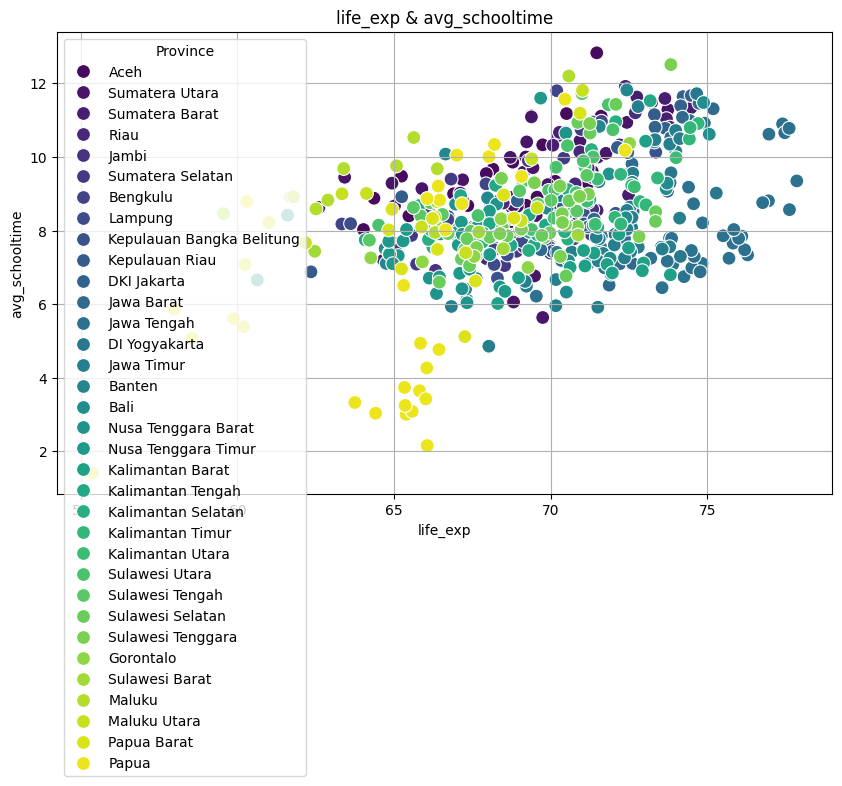

In [287]:
display_city_scatter_plot(data=df, x='life_exp', y='avg_schooltime')

Based on the plot, I will choose a province in yellow (mostly confined to the left side of the graph), a province in purple (mostly in the upper-right) a province in blue (right-central). The provinces I have chosen are:
- Aceh
- Papua
- Jawa Tengah

I will now examine the plot with the reduced provinces.

In [288]:
# Helper function to display provinces in consistent colors
def display_plot_with_color_map(data, hue='province', title=''):
    color_map = {
        'Aceh': 'Blue',
        'Jawa Tengah': 'Yellow',
        'Papua Barat': 'Green'
    }
    
    display_city_scatter_plot(data=data, x='life_exp', y='avg_schooltime', hue=hue, palette=color_map, title=title)

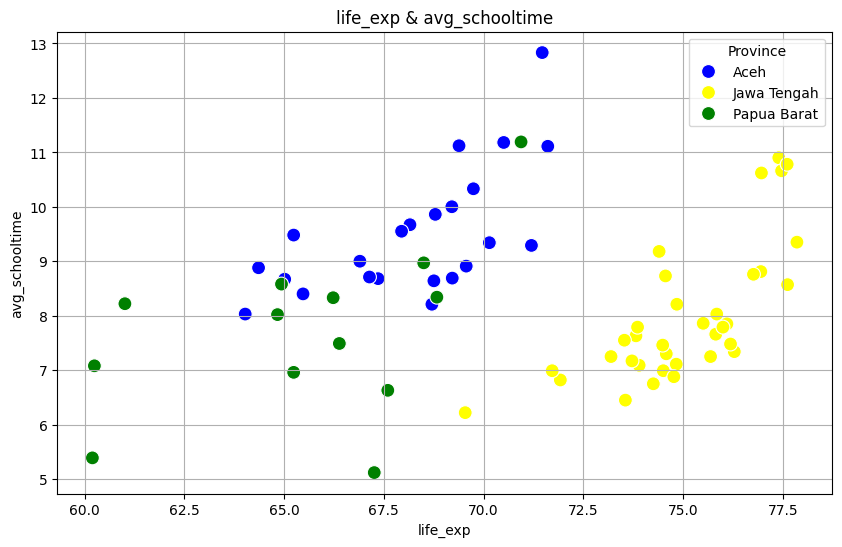

In [289]:
filtered_provinces = ['Aceh', 'Papua Barat', 'Jawa Tengah']

reduced_provinces_df = df[df['province'].isin(filtered_provinces)]

display_plot_with_color_map(data=reduced_provinces_df)

### Training the SVM

I wll now train a SVM on the reduced province data. I will be using sklearn's SVC instead of LinearSVC since the reduced dataset I will use is relatively small.

In [290]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Extract features and labels
X = reduced_provinces_df[['life_exp', 'avg_schooltime']]
y = reduced_provinces_df['province']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the SVM classifier
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

#### Visualizing Providence Predictions

To now get an intuitive sense at the performance of the trained SVC, I will visually compare plots of the test data colored according to their actual provinces, vs their predicted provinces. 

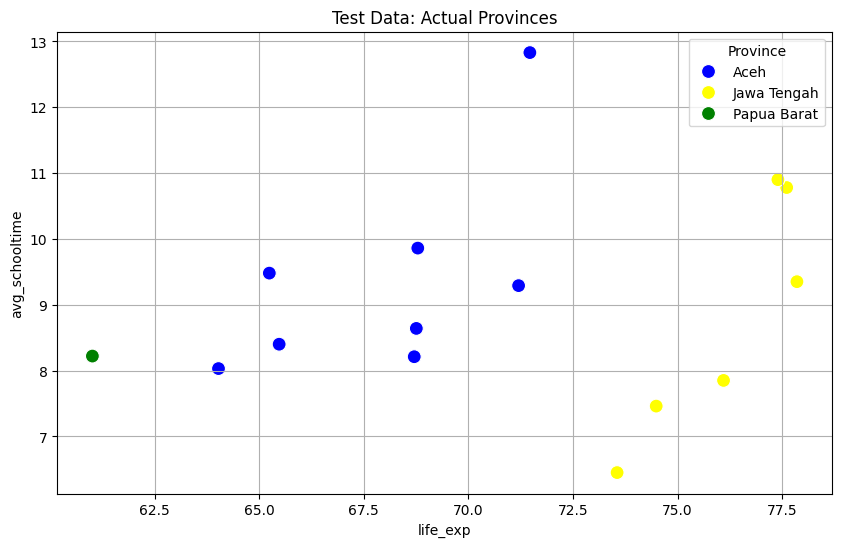

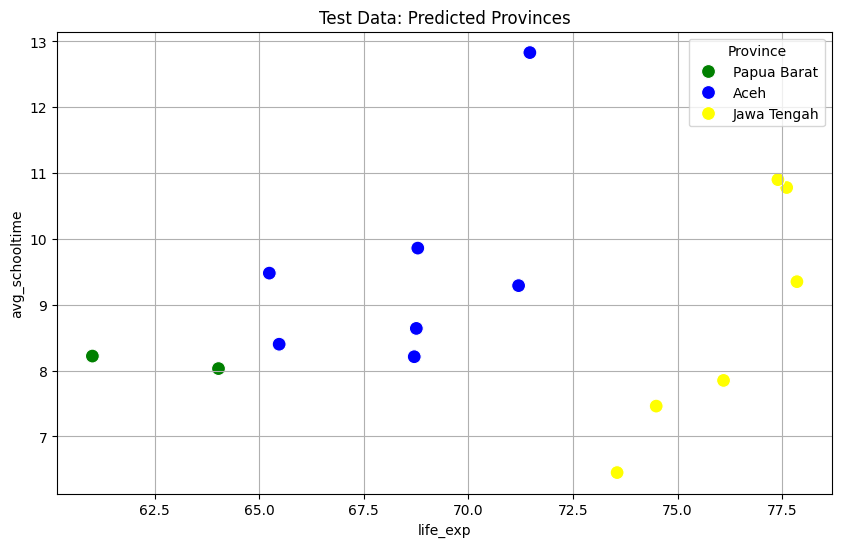

In [291]:
actual_viz_df = pd.DataFrame({
    'life_exp': X_test['life_exp'],
    'avg_schooltime': X_test['avg_schooltime'],
    'province': y_test
})

display_plot_with_color_map(data=actual_viz_df, title='Test Data: Actual Provinces')


predictions_viz_df = pd.DataFrame({
    'life_exp': X_test['life_exp'],
    'avg_schooltime': X_test['avg_schooltime'],
    'predicted_province': y_pred
})

display_plot_with_color_map(data=predictions_viz_df, hue='predicted_province', title='Test Data: Predicted Provinces')

### Classification Report

I will now examine accuracy and classification report for the SVC's performance. 

Overall the SVC performs fairly well, with an accuracy over 90%.

In [292]:
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.93
              precision    recall  f1-score   support

        Aceh       1.00      0.88      0.93         8
 Jawa Tengah       1.00      1.00      1.00         6
 Papua Barat       0.50      1.00      0.67         1

    accuracy                           0.93        15
   macro avg       0.83      0.96      0.87        15
weighted avg       0.97      0.93      0.94        15



### Comparing Other Kernels

I will now try other kernels available to the SVC, to see if I get better performance from a different kernel.

In [293]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    print(f'Kernel: {kernel}')
    svm = SVC(kernel=kernel, C=1)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}\n')

Kernel: linear
Accuracy: 0.93

Kernel: poly
Accuracy: 0.87

Kernel: rbf
Accuracy: 0.40

Kernel: sigmoid
Accuracy: 0.40



When comparing accuracy of the other kernels, I see that the 'linear' kernel remains the best.

### Comparing C Values

I will now try changing the "C" hyperparameter to see if I get a better result.

In [294]:
c = 0.1
while c < 5:
    print(f'C value: {c}')
    svm = SVC(kernel='linear', C=c)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.5f}\n')
    
    c += .1

C value: 0.1
Accuracy: 0.86667

C value: 0.2
Accuracy: 0.86667

C value: 0.30000000000000004
Accuracy: 0.86667

C value: 0.4
Accuracy: 0.93333

C value: 0.5
Accuracy: 0.93333

C value: 0.6
Accuracy: 0.93333

C value: 0.7
Accuracy: 0.93333

C value: 0.7999999999999999
Accuracy: 0.93333

C value: 0.8999999999999999
Accuracy: 0.93333

C value: 0.9999999999999999
Accuracy: 0.93333

C value: 1.0999999999999999
Accuracy: 0.80000

C value: 1.2
Accuracy: 0.80000

C value: 1.3
Accuracy: 0.80000

C value: 1.4000000000000001
Accuracy: 0.80000

C value: 1.5000000000000002
Accuracy: 0.80000

C value: 1.6000000000000003
Accuracy: 0.80000

C value: 1.7000000000000004
Accuracy: 0.80000

C value: 1.8000000000000005
Accuracy: 0.80000

C value: 1.9000000000000006
Accuracy: 0.80000

C value: 2.0000000000000004
Accuracy: 0.80000

C value: 2.1000000000000005
Accuracy: 0.80000

C value: 2.2000000000000006
Accuracy: 0.80000

C value: 2.3000000000000007
Accuracy: 0.80000

C value: 2.400000000000001
Accuracy: 0

After examining the other C values, none of them produce better results than the value 1 that I started with.

## Conclusion

In conclusion, I was surprised at the accuracy of the machine learning predictions for both of the problems I explored with my relatively small dataset: 

I was able to predict life expectancy of a city with considerable accuracy based on the city's province, expenditure per capita, percentage of poor people, and average schooltime.

I was able to predict the province of a city with considerable accuracy based on the life expectacy and average school time.

Overall, my conclusions based on this project is that, for Indonesian cities in 2021, life expectancy was most strongly dependant on the city's province, but that financial and educational factors play a role as well.  